<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/DataSciUnit7Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Install and import datasets, xarray, and bambi libraries
!pip install datasets
from datasets import load_dataset

!pip install git+https://github.com/pydata/xarray.git
import xarray as xr

!pip install bambi
import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.6 MB/s eta 0:00:00
  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-shx16gpb
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-shx16gpb
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=0a9ed201178e3b947da10cfa43b0b2b0887d55c5a8fc14b310bd5d796a8d6970
  Stored in directory: /tmp/pip-ephem-wheel-cache-u6bkn5i9/wheels/15/f9/46/a

In [3]:
#Import other libraries
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sb

Computer CPUs have a variety of components, which leads to several characteristics for understanding how a CPU performs. With so many CPU statistics, it is difficult to compare CPUs, so a single summary statistic, relative performance, was created. I will predict published relative performance with CPU vendor name, machine cycle time, min and max main memory, cache memory, and min and max channels.

# Data

In [4]:
hardware = pd.read_csv('https://raw.githubusercontent.com/jacksone1/DataSci/refs/heads/main/machine.csv')
#We are uninterested in the model name and estimate statistic, so they will be dropped
hardware.drop(columns=["ModelName", "ERP"], inplace=True)

array([[<Axes: xlabel='MYCT', ylabel='MYCT'>,
        <Axes: xlabel='MMIN', ylabel='MYCT'>,
        <Axes: xlabel='MMAX', ylabel='MYCT'>,
        <Axes: xlabel='CACH', ylabel='MYCT'>,
        <Axes: xlabel='CHMIN', ylabel='MYCT'>,
        <Axes: xlabel='CHMAX', ylabel='MYCT'>,
        <Axes: xlabel='PRP', ylabel='MYCT'>],
       [<Axes: xlabel='MYCT', ylabel='MMIN'>,
        <Axes: xlabel='MMIN', ylabel='MMIN'>,
        <Axes: xlabel='MMAX', ylabel='MMIN'>,
        <Axes: xlabel='CACH', ylabel='MMIN'>,
        <Axes: xlabel='CHMIN', ylabel='MMIN'>,
        <Axes: xlabel='CHMAX', ylabel='MMIN'>,
        <Axes: xlabel='PRP', ylabel='MMIN'>],
       [<Axes: xlabel='MYCT', ylabel='MMAX'>,
        <Axes: xlabel='MMIN', ylabel='MMAX'>,
        <Axes: xlabel='MMAX', ylabel='MMAX'>,
        <Axes: xlabel='CACH', ylabel='MMAX'>,
        <Axes: xlabel='CHMIN', ylabel='MMAX'>,
        <Axes: xlabel='CHMAX', ylabel='MMAX'>,
        <Axes: xlabel='PRP', ylabel='MMAX'>],
       [<Axes: xlabel='MYCT'

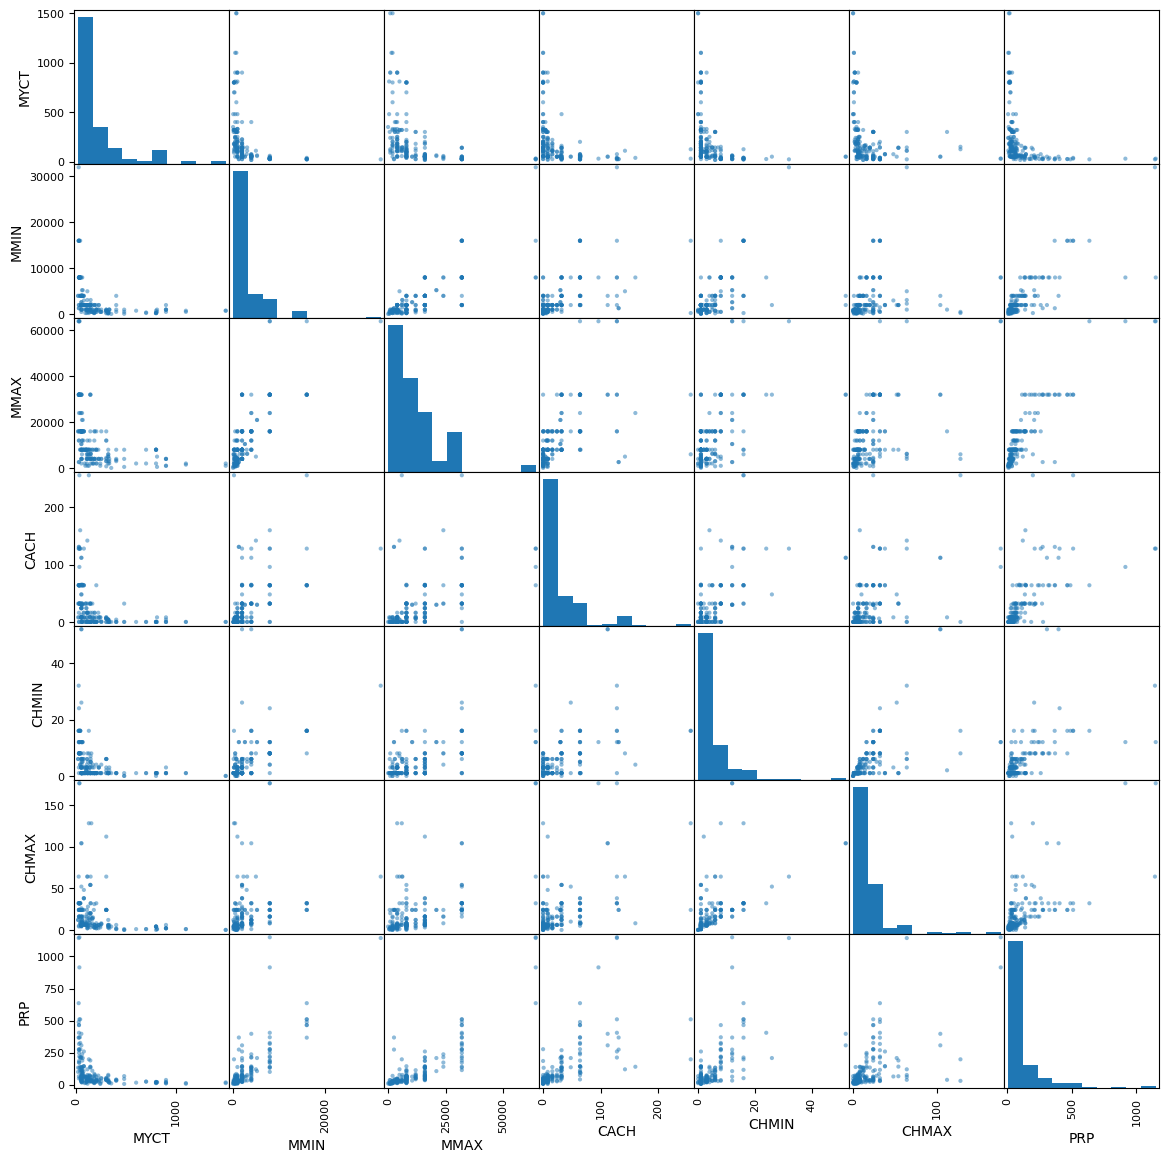

In [5]:
pd.plotting.scatter_matrix(hardware, figsize=(14,14))

From an initial view of the predictors plotted against PRP (published relative performance), each pair seems to have an upward trend. Thus, a model including each of them will likely be better than a model with any single predictor. Next, single predictor linear models will be created, as will a linear reference model with all predictors.

# Model Creation Function

In [8]:
#Create models for each individual predictor and return a list of idata
#Dataframe, predicted variable name, degree of polynomial regression, excluded predictor name list
def GetSingleModels(df, predicted, degree=1, exclusions=[], variable_variance=False, vv_degree=1):
  #Create a dictionary for idata by formula
  single_models = {}
  #For each predictor column in the dataframe df
  for col in df:
    if col != predicted and col not in exclusions:
      #Print the formula
      if degree == 1:
        formula_str = predicted + " ~ " + col
      else:
        formula_str = predicted + " ~ poly(" + col + ", degree=" + str(degree) + ")"
      if variable_variance:
        vv_str = "sigma ~ poly(" + col + ", degree=" + str(vv_degree) + ")"
        print("Creating model: " + formula_str + ", " + vv_str)
        formula = bmb.Formula(formula_str, vv_str)
      else:
        print("Creating model: " + formula_str)
        formula = bmb.Formula(formula_str)
      #Get the idata for the model
      current_model = bmb.Model(formula, data=df)
      current_idata = current_model.fit(idata_kwargs={"log_likelihood":True})
      #Record the idata in the dictionary with its formula as the key
      if(variable_variance):
        single_models[formula_str + ", " + vv_str] = (current_model, current_idata)
      else:
        single_models[formula_str] = (current_model, current_idata)
  return(single_models)

# Linear Models

In [9]:
single_models = GetSingleModels(hardware, "PRP")

Creating model: PRP ~ VendorName


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Creating model: PRP ~ MYCT


Output()

Creating model: PRP ~ MMIN


Output()

Creating model: PRP ~ MMAX


Output()

Creating model: PRP ~ CACH


Output()

Creating model: PRP ~ CHMIN


Output()

Creating model: PRP ~ CHMAX


Output()

In [10]:
#Get the idata for the reference model
ref_model = bmb.Model("PRP ~ VendorName + MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX", data=hardware)
ref_idata = ref_model.fit(idata_kwargs={"log_likelihood":True})

Output()

In [11]:
single_idatas = dict(zip(single_models.keys(), (v[1] for v in single_models.values())))
linear_compare = az.compare(single_idatas | {"Reference":ref_idata})
linear_compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Reference,0,-1164.171731,47.919673,0.000000,9.113412e-01,25.820970,0.000000,True,log
PRP ~ MMAX,1,-1224.190930,13.035612,60.019200,1.969257e-10,26.829249,16.742598,True,log
PRP ~ MMIN,2,-1267.072479,22.438557,102.900748,5.778122e-02,54.026777,40.571984,True,log
PRP ~ CACH,3,-1309.583484,18.806506,145.411753,1.427215e-02,38.233327,29.066779,True,log
PRP ~ CHMAX,4,-1320.279977,15.178912,156.108246,1.660542e-02,31.087167,27.971951,True,log
PRP ~ CHMIN,5,-1322.590296,20.521928,158.418566,7.517025e-11,39.271191,28.612179,True,log
PRP ~ VendorName,6,-1352.735600,28.486191,188.563869,0.000000e+00,31.578493,22.741668,True,log
PRP ~ MYCT,7,-1355.948650,12.243166,191.776920,0.000000e+00,36.970078,27.612505,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

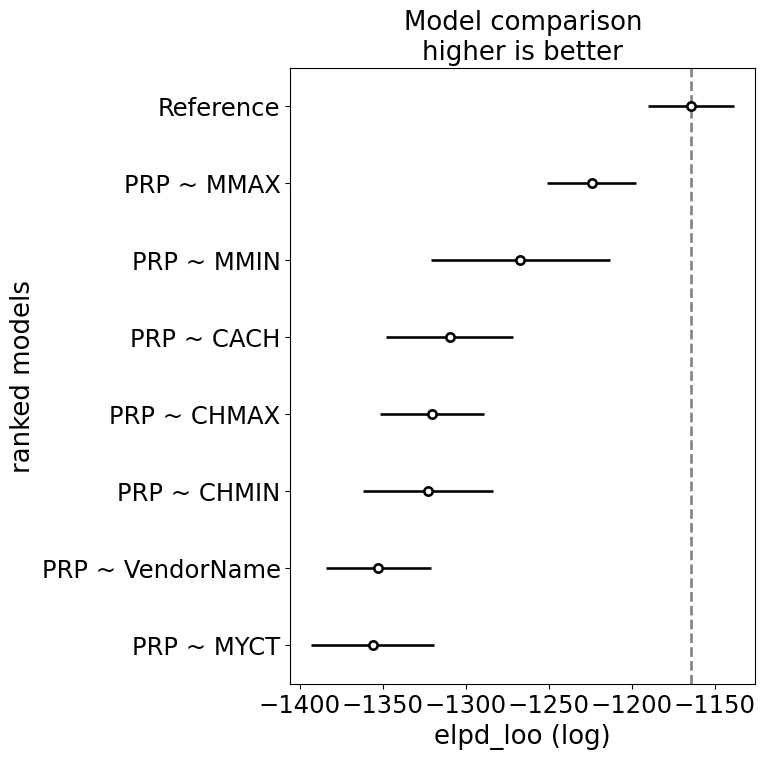

In [12]:
az.plot_compare(linear_compare)

As suspected, the reference did better than the single predictor linear models. However, some of predictor plots above were not clearly of a linear trend, so third degree single predictor models will be created as well.

# Third Degree Polynomial Models

In [13]:
third_degree_models = GetSingleModels(hardware, "PRP", 3, "VendorName")

Creating model: PRP ~ poly(MYCT, degree=3)


Output()

Creating model: PRP ~ poly(MMIN, degree=3)


Output()

Creating model: PRP ~ poly(MMAX, degree=3)


Output()

Creating model: PRP ~ poly(CACH, degree=3)


Output()

Creating model: PRP ~ poly(CHMIN, degree=3)


Output()

Creating model: PRP ~ poly(CHMAX, degree=3)


Output()

The third degree models will be compared to their linear counterparts, though Vendor Name was excluded from the third degree modeling as a categorical predictor.

In [14]:
third_degree_idatas = dict(zip(third_degree_models.keys(), (v[1] for v in third_degree_models.values())))
third_degree_compare = az.compare(single_idatas | third_degree_idatas)
third_degree_compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
"PRP ~ poly(MMAX, degree=3)",0,-1184.303959,18.878740,0.000000,9.997520e-01,25.814771,0.000000,True,log
PRP ~ MMAX,1,-1224.190930,13.035612,39.886971,2.479640e-04,26.829249,23.405779,True,log
PRP ~ MMIN,2,-1267.072479,22.438557,82.768520,2.034430e-09,54.026777,53.851506,True,log
"PRP ~ poly(MMIN, degree=3)",3,-1268.087080,22.628362,83.783121,1.948252e-09,53.671021,53.443483,True,log
"PRP ~ poly(CACH, degree=3)",4,-1296.563937,22.674351,112.259978,4.032946e-08,35.812162,35.093778,True,log
"PRP ~ poly(CHMAX, degree=3)",5,-1299.581351,19.533495,115.277392,4.027387e-08,41.865524,40.477874,True,log
"PRP ~ poly(CHMIN, degree=3)",6,-1300.481588,23.832271,116.177629,4.028044e-08,41.395952,42.546445,True,log
PRP ~ CACH,7,-1309.583484,18.806506,125.279524,4.013979e-08,38.233327,36.897287,True,log
PRP ~ CHMAX,8,-1320.279977,15.178912,135.976018,3.969689e-08,31.087167,30.039780,True,log
PRP ~ CHMIN,9,-1322.590296,20.521928,138.286337,3.985936e-08,39.271191,39.453974,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

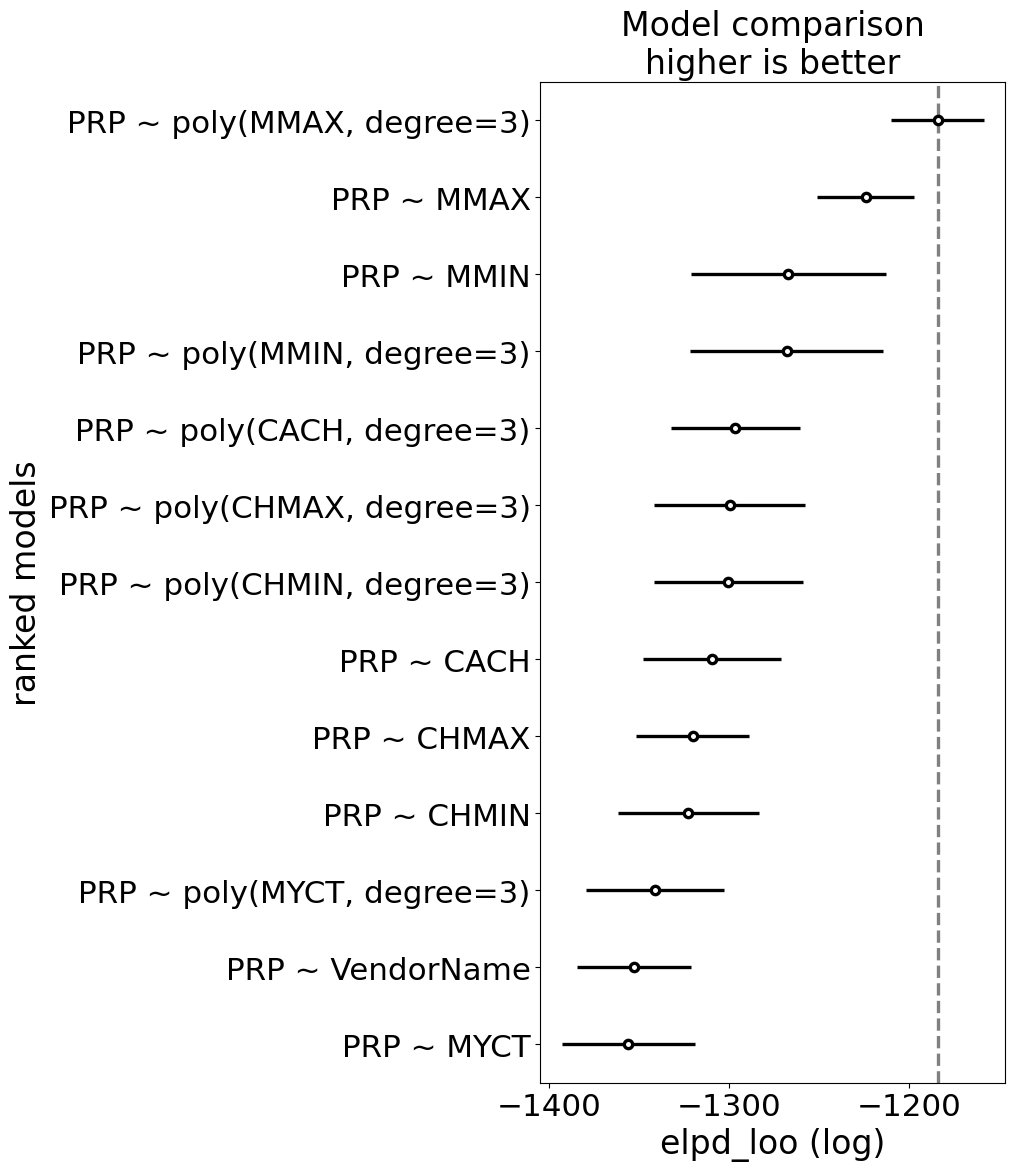

In [15]:
az.plot_compare(third_degree_compare)

The third degree regression bettered the performance of the Maximum main memory (MMAX) model the most. Even so, the increase in elpd_loo was not vast, so it may be preferable to use the simpler linear model for MMAX. The other predictor models do not perform much better with the higher degree.

# Exploring MMAX

The MMAX model predictive lines will be plotted against the data to examine whether a third degree polynomial seems more sensical or might be overfitting.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


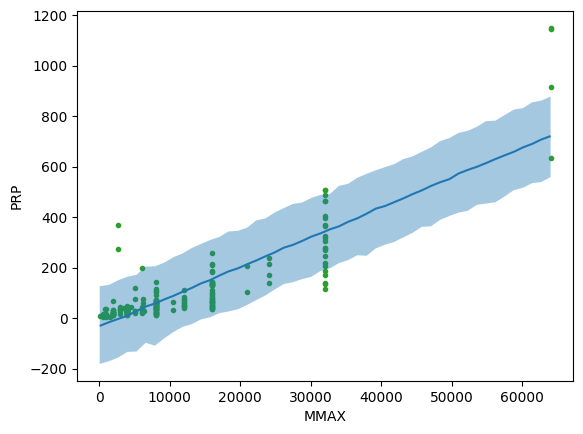

In [16]:
#Plot of posterior predictive distribution
bmb.interpret.plot_predictions(single_models['PRP ~ MMAX'][0], single_models['PRP ~ MMAX'][1], "MMAX", pps=True)
#Raw data
plt.plot(hardware.MMAX, hardware.PRP, "C2.", zorder=-3)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


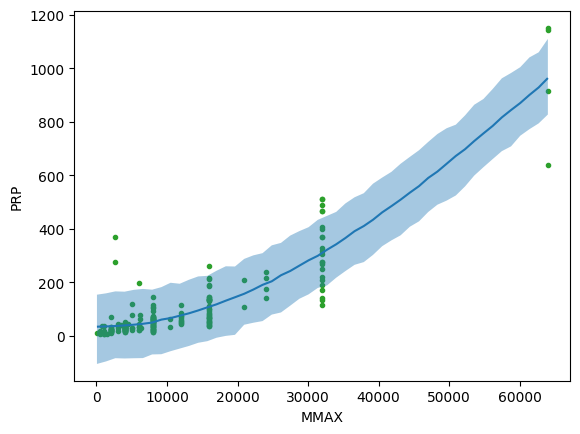

In [17]:
#Plot of posterior predictive distribution
bmb.interpret.plot_predictions(third_degree_models['PRP ~ poly(MMAX, degree=3)'][0], third_degree_models['PRP ~ poly(MMAX, degree=3)'][1], "MMAX", pps=True)
#Raw data
plt.plot(hardware.MMAX, hardware.PRP, "C2.", zorder=-3)

Both the linear and third degree prediction lines seem plausable, and it is not clear given the context whether one makes more sense than the other. Given that the third degree model predcicts slightly better according to elpd_loo and the minimum PRP for each memory level seems to rise similarly to the curve of the third degree model, the third degree polynomial may be used for the next all-predictor model.

The variance in the PRP against MMAX seems to vary with increasing MMAX, so variable variance models will be created for this relationship.

In [18]:
MMAX_formula_vv = bmb.Formula("PRP ~ poly(MMAX, degree=3)", "sigma ~ poly(MMAX, degree=1)")
MMAX_model_vv = bmb.Model(MMAX_formula_vv, hardware)
MMAX_idata_vv = MMAX_model_vv.fit(idata_kwargs={"log_likelihood":True})

MMAX_formula_vv3 = bmb.Formula("PRP ~ poly(MMAX, degree=3)", "sigma ~ poly(MMAX, degree=3)")
MMAX_model_vv3 = bmb.Model(MMAX_formula_vv3, hardware)
MMAX_idata_vv3 = MMAX_model_vv3.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


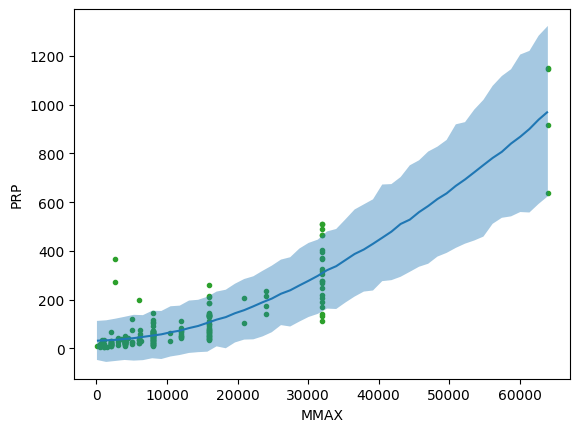

In [19]:
#Plot of posterior predictive distribution
bmb.interpret.plot_predictions(MMAX_model_vv, MMAX_idata_vv, "MMAX", pps=True)
#Raw data
plt.plot(hardware.MMAX, hardware.PRP, "C2.", zorder=-3)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


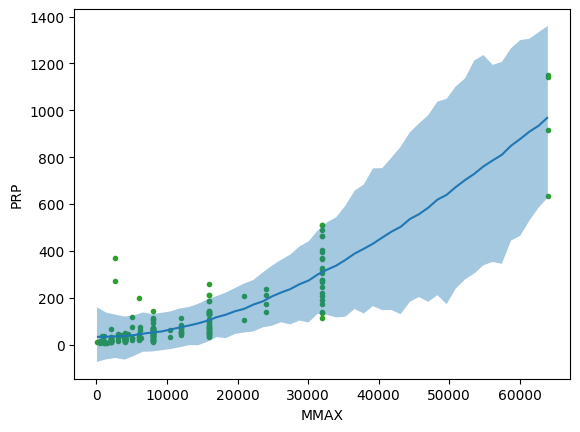

In [20]:
#Plot of posterior predictive distribution
bmb.interpret.plot_predictions(MMAX_model_vv3, MMAX_idata_vv3, "MMAX", pps=True)
#Raw data
plt.plot(hardware.MMAX, hardware.PRP, "C2.", zorder=-3)

In [21]:
MMAX_compare = az.compare({"Linear": single_models['PRP ~ MMAX'][1], "Third": third_degree_models['PRP ~ poly(MMAX, degree=3)'][1], "Variable Variance": MMAX_idata_vv, "Variable Variance Degree 3": MMAX_idata_vv, "Reference": ref_idata})
MMAX_compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Variable Variance,0,-1149.063905,21.810489,0.000000,3.562464e-01,39.076126,0.000000,True,log
Variable Variance Degree 3,1,-1149.063905,21.810489,0.000000,3.562464e-01,39.076126,0.000000,True,log
Reference,2,-1164.171731,47.919673,15.107826,2.875073e-01,25.820970,36.667380,True,log
Third,3,-1184.303959,18.878740,35.240054,0.000000e+00,25.814771,26.567373,True,log
Linear,4,-1224.190930,13.035612,75.127026,3.500276e-10,26.829249,33.239138,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

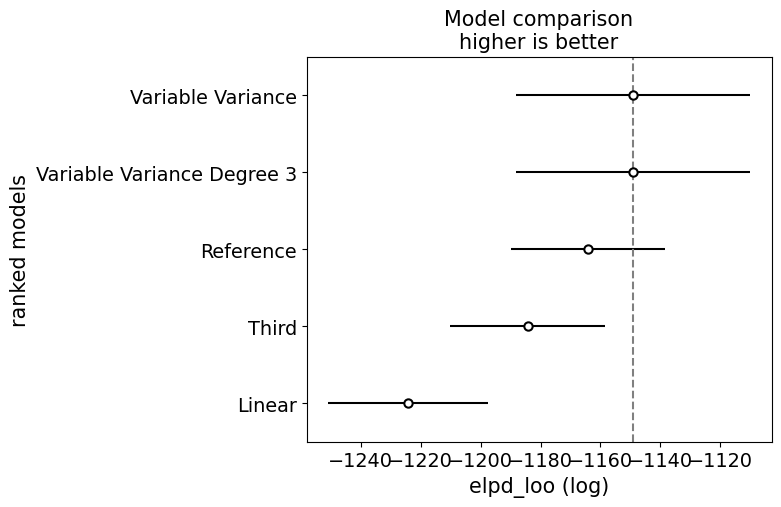

In [22]:
az.plot_compare(MMAX_compare)

Incorporating variable variance and a third degree polynomial component to the MMAX model resulted in a higher elpd_loo than the reference model with all predictors linearly included. A third degree variable variance term seems unnecessary over a first degree one though. Other predictors had similar data trends when plotted against PRP, so variable variance models will be created for all parameters.

# Variable Variance Models

In [23]:
vv1_models = GetSingleModels(hardware, "PRP", 1, "VendorName", True)
vv3_models = GetSingleModels(hardware, "PRP", 1, "VendorName", True, 3)

Creating model: PRP ~ MYCT, sigma ~ poly(MYCT, degree=1)


Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Creating model: PRP ~ MMIN, sigma ~ poly(MMIN, degree=1)


Output()

Creating model: PRP ~ MMAX, sigma ~ poly(MMAX, degree=1)


Output()

Creating model: PRP ~ CACH, sigma ~ poly(CACH, degree=1)


Output()

Creating model: PRP ~ CHMIN, sigma ~ poly(CHMIN, degree=1)


Output()

Creating model: PRP ~ CHMAX, sigma ~ poly(CHMAX, degree=1)


Output()

Creating model: PRP ~ MYCT, sigma ~ poly(MYCT, degree=3)


Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Creating model: PRP ~ MMIN, sigma ~ poly(MMIN, degree=3)


Output()

ERROR:pymc.stats.convergence:There were 34 divergences after tuning. Increase `target_accept` or reparameterize.


Creating model: PRP ~ MMAX, sigma ~ poly(MMAX, degree=3)


Output()

Creating model: PRP ~ CACH, sigma ~ poly(CACH, degree=3)


Output()

Creating model: PRP ~ CHMIN, sigma ~ poly(CHMIN, degree=3)


Output()

Creating model: PRP ~ CHMAX, sigma ~ poly(CHMAX, degree=3)


Output()

In [24]:
vv1_idatas = dict(zip(vv1_models.keys(), (v[1] for v in vv1_models.values())))
vv3_idatas = dict(zip(vv3_models.keys(), (v[1] for v in vv3_models.values())))
vv_compare = az.compare(single_idatas | vv1_idatas | vv3_idatas | {"Reference":ref_idata, "PRP ~ poly(MMAX, degree=3), sigma ~ poly(MMAX, degree=1)":MMAX_idata_vv})
vv_compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
"PRP ~ poly(MMAX, degree=3), sigma ~ poly(MMAX, degree=1)",0,-1149.063905,21.810489,0.000000,8.119080e-01,39.076126,0.000000,True,log
"PRP ~ CACH, sigma ~ poly(CACH, degree=3)",1,-1149.973267,17.711555,0.909362,0.000000e+00,32.975516,46.681692,True,log
"PRP ~ MMAX, sigma ~ poly(MMAX, degree=3)",2,-1150.609488,16.982443,1.545583,7.956411e-08,32.626275,9.304892,True,log
"PRP ~ CACH, sigma ~ poly(CACH, degree=1)",3,-1154.866476,11.088010,5.802571,0.000000e+00,28.647806,44.008828,True,log
"PRP ~ MMAX, sigma ~ poly(MMAX, degree=1)",4,-1162.852842,18.491113,13.788937,8.091889e-08,40.650333,6.807659,True,log
Reference,5,-1164.171731,47.919673,15.107826,2.628866e-02,25.820970,36.667380,True,log
"PRP ~ CHMAX, sigma ~ poly(CHMAX, degree=3)",6,-1167.002179,7.666187,17.938274,4.331889e-07,19.802300,37.657276,True,log
"PRP ~ MMIN, sigma ~ poly(MMIN, degree=3)",7,-1183.207421,19.774422,34.143516,1.618005e-01,34.363517,30.838733,True,log
"PRP ~ CHMIN, sigma ~ poly(CHMIN, degree=3)",8,-1191.077940,15.735017,42.014035,1.155038e-07,29.652748,44.612734,True,log
"PRP ~ MMIN, sigma ~ poly(MMIN, degree=1)",9,-1206.683149,17.648811,57.619245,4.891535e-08,37.895009,39.717209,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

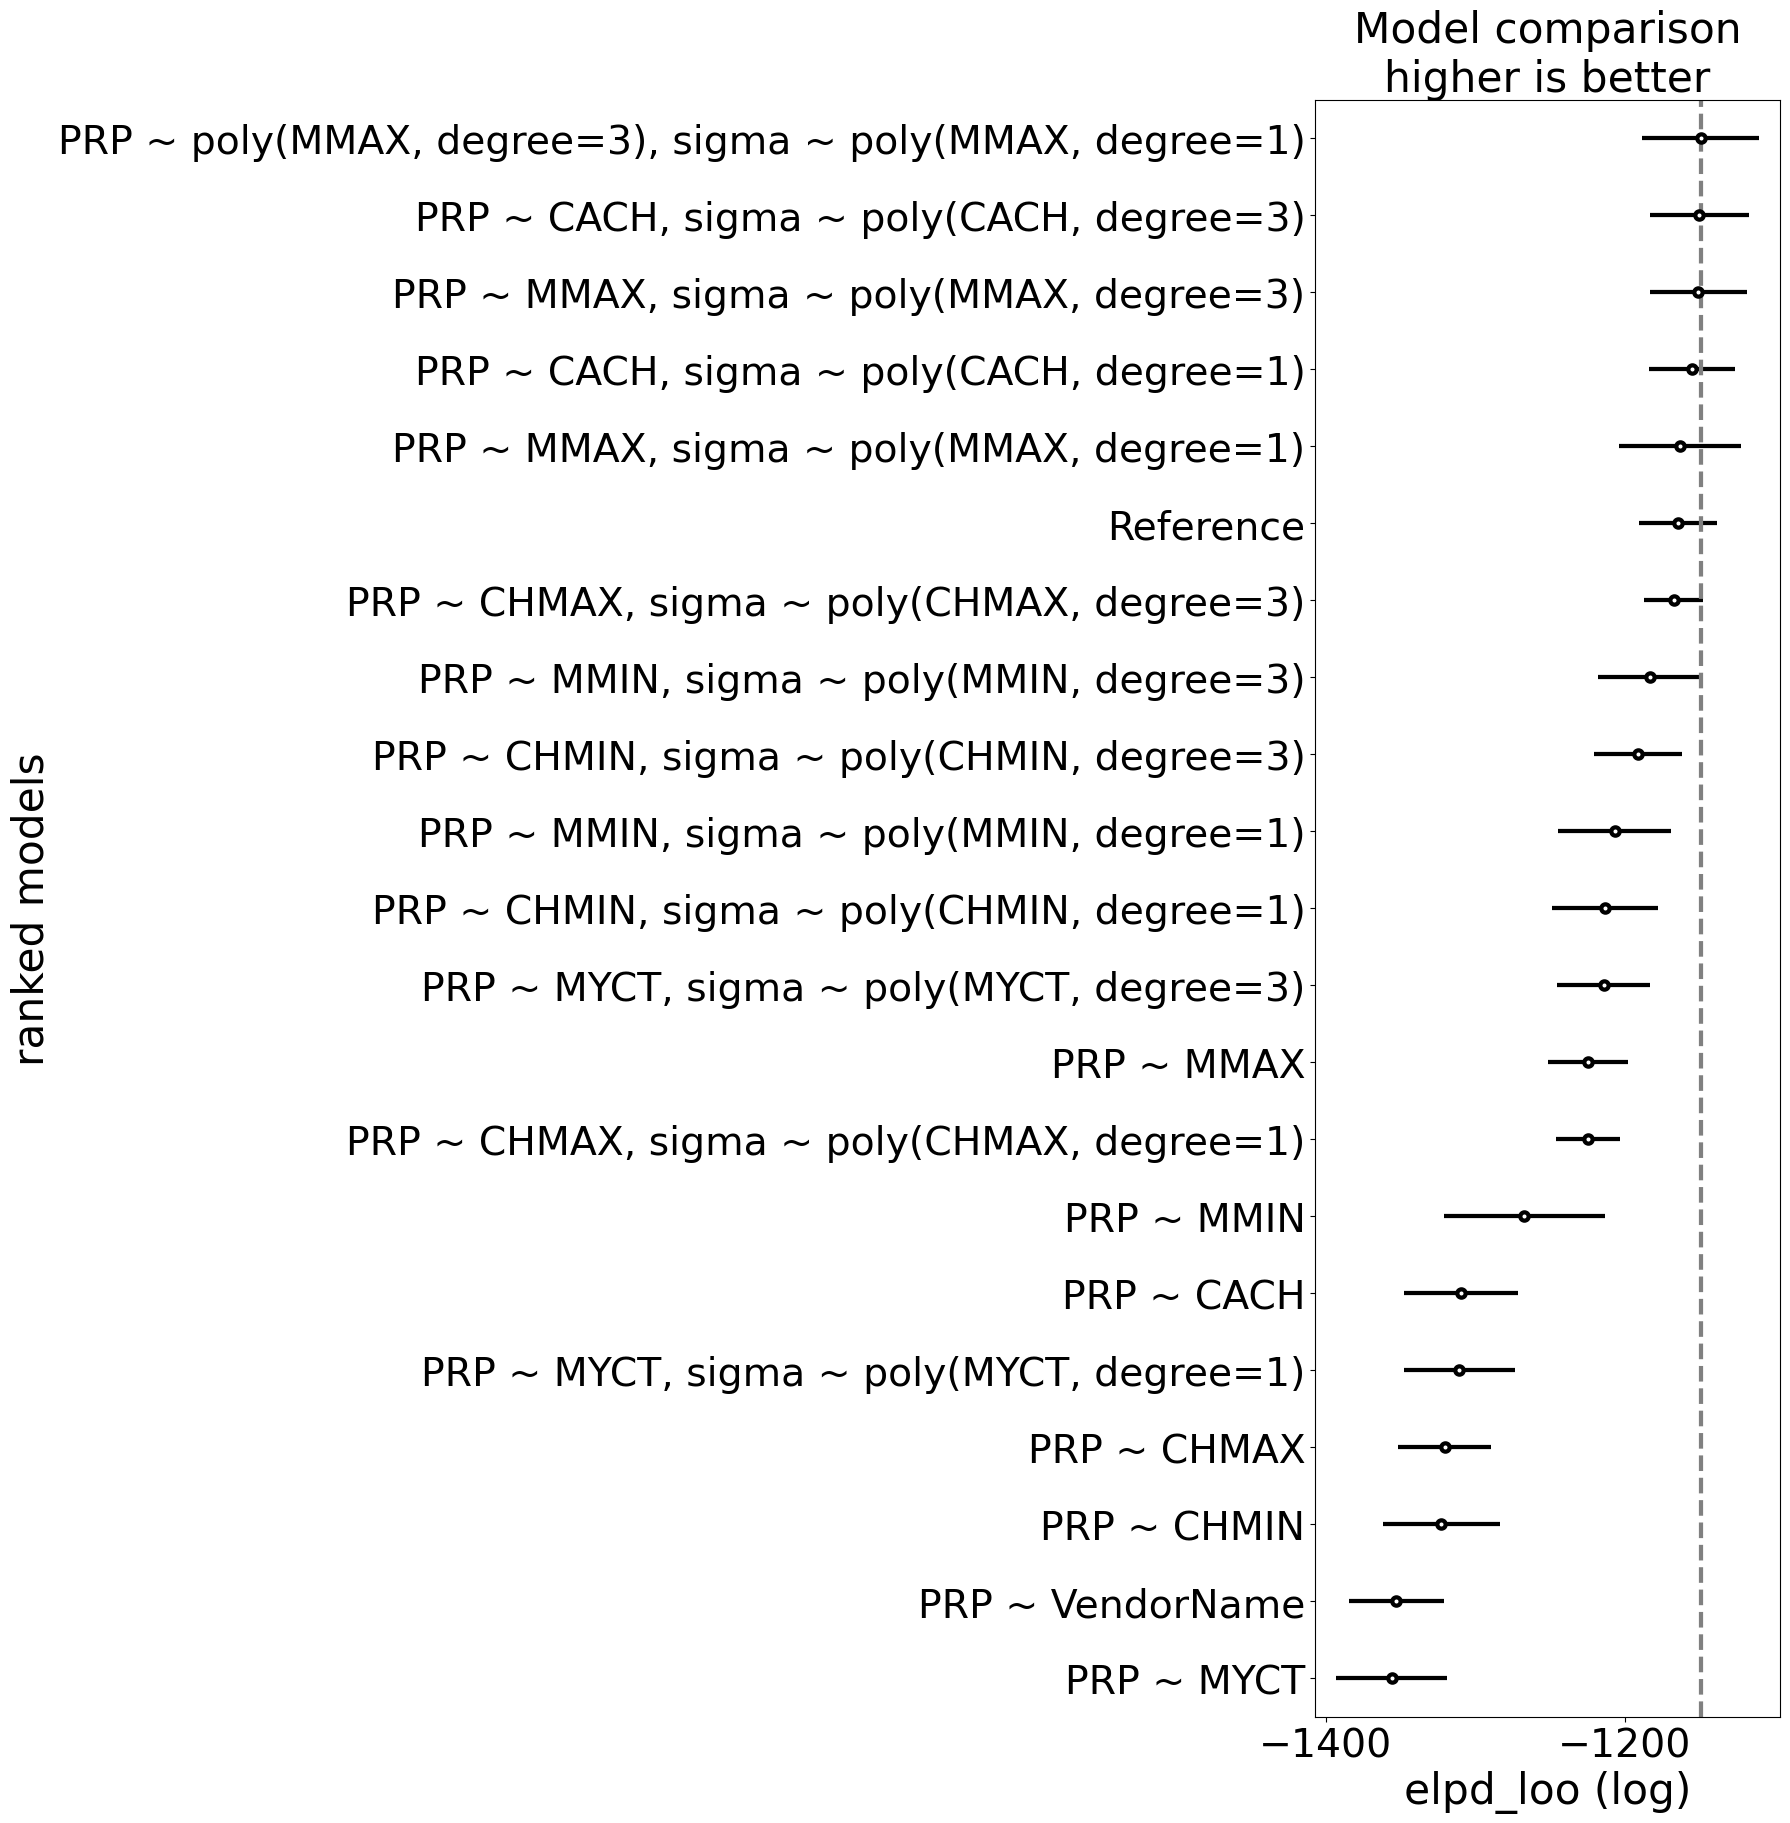

In [25]:
az.plot_compare(vv_compare)

Fascinatingly, several of the models, CHMAX in particular, did vastly better when standard deviation could vary as a first or third degree term. On the note of MMAX, it appears a third degree polynomial was not actually necessary so much as a variable variance term. From this comparison diagram, it seems that the original reference model (all predictors with no variable variance) does about as well as the MMAX degree 1 variable variance model. It is interesting that a model with only one predictor can roughly match the reference model. For simplicity, the MMAX V.V. model may be the best choice. The models with similar, but greater elpd_loo than the MMAX V.V. model are disfavored for greater complexity. New all-predictor models will be created by incorporating the best single model constructions so far. For models of the same predictor and similar elpd_loo, lesser degree polynomial terms will be favored to avoid overfitting.

# Final All Predictor Model

In [45]:
#Get the idata for the second all-predictor model
all2_formula = bmb.Formula("PRP ~ MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX", "sigma ~ MYCT")
all2_model = bmb.Model(all2_formula, data=hardware)
all2_idata = all2_model.fit(idata_kwargs={"log_likelihood":True})

Output()

In [52]:
#Get the idata for the second all-predictor model
all3_formula = bmb.Formula("PRP ~ MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX", "sigma ~ poly(MYCT, degree=3)")
all3_model = bmb.Model(all3_formula, data=hardware)
all3_idata = all3_model.fit(idata_kwargs={"log_likelihood":True})

Output()

ERROR:pymc.stats.convergence:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


In [53]:
#Get the idata for the second all-predictor model
all4_formula = bmb.Formula("PRP ~ MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX", "sigma ~ poly(MYCT, degree=3) + poly(MMIN, degree=3)")
all4_model = bmb.Model(all4_formula, data=hardware)
all4_idata = all4_model.fit(idata_kwargs={"log_likelihood":True})

Output()

ERROR:pymc.stats.convergence:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [58]:
#Get the idata for the second all-predictor model
all5_formula = bmb.Formula("PRP ~ MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX", "sigma ~ poly(MYCT, degree=3) + poly(MMIN, degree=3) + CACH")
all5_model = bmb.Model(all5_formula, data=hardware)
all5_idata = all5_model.fit(idata_kwargs={"log_likelihood":True})

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [61]:
#Get the idata for the second all-predictor model
all6_formula = bmb.Formula("PRP ~ MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX", "sigma ~ poly(MYCT, degree=3) + poly(MMIN, degree=3) + poly(CACH, degree=3)")
all6_model = bmb.Model(all6_formula, data=hardware)
all6_idata = all6_model.fit(idata_kwargs={"log_likelihood":True})

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Not using degree 3 variable variance terms seems to slow down the model creation by minutes. Degree 3 will be used for each V.V. term from here.

In [64]:
#Get the idata for the second all-predictor model
all7_formula = bmb.Formula("PRP ~ MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX", "sigma ~ poly(MYCT, degree=3) + poly(MMIN, degree=3) + poly(MMAX, degree=3) + poly(CACH, degree=3) + poly(CHMIN, degree=3) + poly(CHMAX, degree=3)")
all7_model = bmb.Model(all7_formula, data=hardware)
all7_idata = all7_model.fit(idata_kwargs={"log_likelihood":True})

Output()

ERROR:pymc.stats.convergence:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [67]:
# all5 is omitted because the elpd_loo is several orders of magnitude lower, so the plot would be unhelpful
all_compare = az.compare(single_idatas | third_degree_idatas | vv1_idatas | vv3_idatas | {"Reference":ref_idata, "All 2":all2_idata, "All 3":all3_idata, "All 4":all4_idata, "All 6":all6_idata, "All 7":all7_idata})
all_compare

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
All 7,0,-988.432069,20.200679,0.000000,9.168387e-01,18.951936,0.000000,True,log
All 6,1,-1004.716307,18.613243,16.284238,3.676814e-02,21.144177,10.611771,True,log
All 4,2,-1071.361639,29.178560,82.929570,6.472943e-10,33.419793,24.937447,True,log
All 2,3,-1120.977370,29.922943,132.545301,1.314650e-09,38.242612,34.121006,True,log
All 3,4,-1124.196615,34.094192,135.764546,9.319484e-10,41.727473,37.286981,True,log
"PRP ~ CACH, sigma ~ poly(CACH, degree=3)",5,-1149.973267,17.711555,161.541198,1.871128e-02,32.975516,28.657381,True,log
"PRP ~ MMAX, sigma ~ poly(MMAX, degree=3)",6,-1150.609488,16.982443,162.177419,2.061808e-09,32.626275,27.770103,True,log
"PRP ~ CACH, sigma ~ poly(CACH, degree=1)",7,-1154.866476,11.088010,166.434406,2.563443e-09,28.647806,24.385205,True,log
"PRP ~ MMAX, sigma ~ poly(MMAX, degree=1)",8,-1162.852842,18.491113,174.420773,1.808605e-09,40.650333,35.236892,True,log
Reference,9,-1164.171731,47.919673,175.739662,2.768191e-02,25.820970,24.893918,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

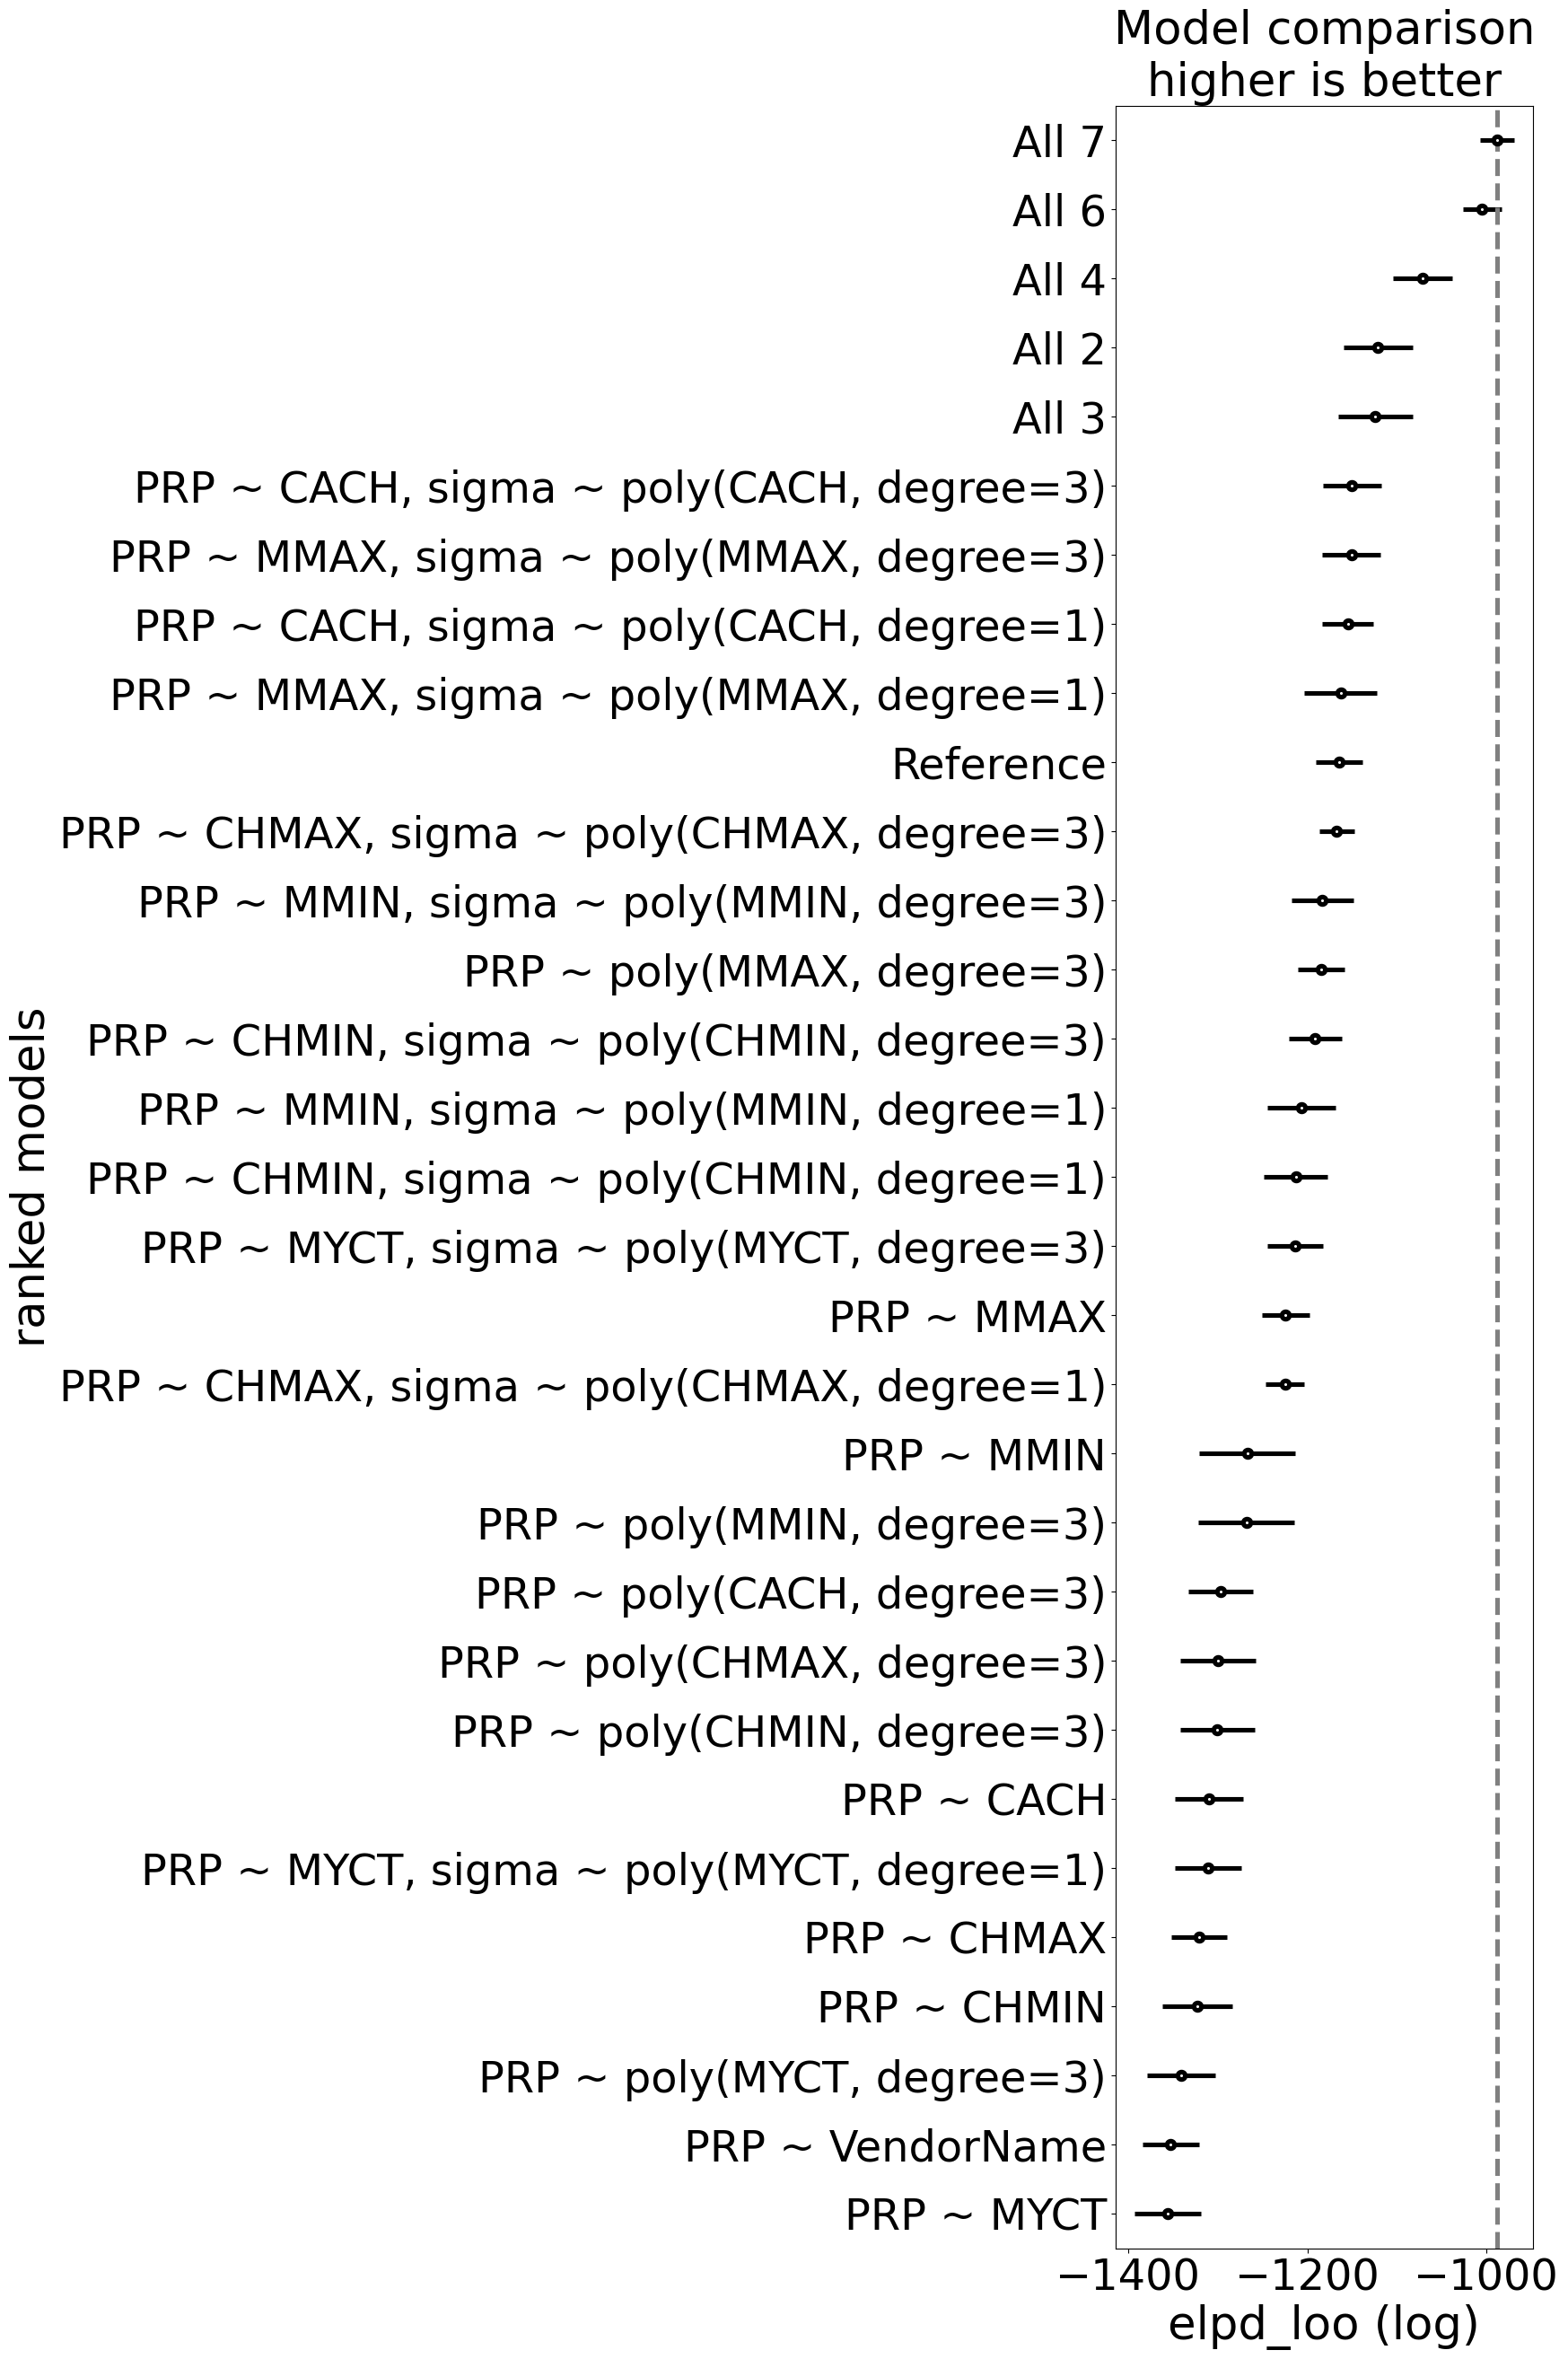

In [68]:
az.plot_compare(all_compare)

The final all-predictor (except vendor name) model, called all7, with third degree variable variance terms for each predictor has the greatest elpd_loo of all the previous models. It appears to be the best option for modelling PRP with the given predictors.